# Neural CA

In this notebook you can train a CA that converges to a given image, like in the Growing Neural Cellular Automata paper

In [1]:
import torch
from torchvision.io import read_image, ImageReadMode
import torchvision.transforms as T

import pylab as pl

from src import *

In [2]:
config = {
    'starting_file':'butterfly_persist.pt',
    'image':'butterfly.png',

    'target_size':40,
    'target_padding':8,
    'n_channels':16,

    'pool_size': 512,

    'start_appling_loss':64,
    'end_appling_loss':np.inf,
    'perturbation_file':'Pretrained_models/lizard/lizard_persist.pt',
    'perturbation_multiplier':1e-3,

    'lr':2e-3,
    'batch_size':10,
    'n_epochs':60,
    'n_max_loss_ratio':8,
    'evolution_iters':96,
    'kind':'persistent',
    'skip_update':1,
    'skip_damage':1,
    'reset_prob':0.,

    'step_size':20,
    'gamma':0.3,

    'trained_model_name': 'bug_regenerating'
    }

config["n_max_losses"] = max(1, config["batch_size"] // config["n_max_loss_ratio"])
config["image_size"] = config["target_size"] + config["target_padding"]

torch.backends.cudnn.benchmark = True  # Speeds up training

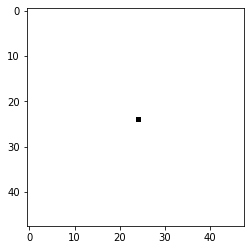

In [3]:
# Starting state
def generator(n, device):
    return make_seed(n, config["n_channels"]-1, config["image_size"], alpha_channel=3, device=device)

pool = SamplePool(config["pool_size"], generator)
imshow(pool[0])

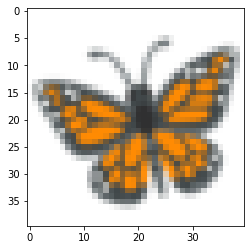

In [8]:
# Imports the target emoji
target = read_image("images/" + config["image"], ImageReadMode.RGB_ALPHA).float()
target = RGBAtoFloat(target)
target = T.ToPILImage()(target)
target = T.Resize((config["target_size"], config["target_size"]))(target)
target = T.ToTensor()(target)

imshow(target)

In [9]:
# Define the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = NeuralCA(config["n_channels"], device)

In [10]:
# Load a pretrained model
model.load(config["starting_file"])

Successfully loaded model!


In [11]:
growing = NeuralCA(config["n_channels"], device)
growing.load(config["perturbation_file"])

for param in growing.parameters():
    param.requires_grad = False

Successfully loaded model!


In [12]:
L_target = NCALoss(pad(target, config["target_padding"]).to(device), alpha_channels=[3])

criterion = CombinedLoss([L_target], [ConstantWeight(config["start_appling_loss"], config["end_appling_loss"])])

model.end_step_loss = NCADistance(model, growing, config["perturbation_multiplier"]*1e-4)

## Train the model

In [13]:
wandb.init(mode="disabled")

In [14]:
params = model.parameters()

optimizer = torch.optim.Adam(params, lr=config["lr"])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, config["step_size"], config["gamma"])

model.train_CA(optimizer, criterion, pool, scheduler=scheduler, **config)

epoch: 60
avg loss: 0.0013108889494712155


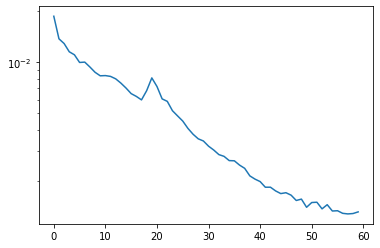

In [15]:
# Plot the losses
pl.plot(model.losses)
pl.yscale("log")

In [19]:
# Save a model
model.save(config["trained_model_name"] + ".pt")

Successfully saved model!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


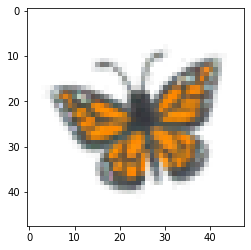

In [17]:
# A pool sample
image, idx = pool.sample(1)
imshow(image[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


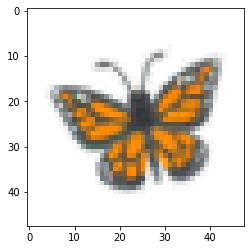

In [18]:
# Evolve the sample
x = model.evolve(image.cuda(), 500)
imshow(x[0])